In [1]:
import pandas as pd
import numpy as np
import warnings
from initts.sioc import sel_satisfy_ts_data,vec_ts_pair_in_dataset,get_diff_ts_desc
from rxnpred.models.utils import get_model
from rxnpred.evaluate.eval import get_val_score_add_data,get_predict
from rxnpred.descriptors.desc import vect_columns_in_dataset,sel_high_corr_desc,reduce_desc_with_corr_matrix
from rxnpred.descriptors.utils import process_desc,maxminscale
from rdkit import RDLogger
from rdkit import Chem
from rxnpred.utils.convert import ddG2ee
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')
from rxnpred.descriptors.utils import canonical_smiles
import itertools
def load_map(map_file):
    inf_map = {}
    with open(map_file,'r') as f:
        lines = f.readlines()
    #print(len(lines)-1)
    for line in lines[1:]:
        smiles = line.strip().split("'")[1]
        index = line.strip().split("'")[2].split(',')[1]
        inf_map[smiles] = int(index)
    return inf_map

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
merge_method = "delta"
dist_type = "euclidean"
base_rct_keys = ["Reactant1","Reactant2"]
target_rct_keys = ["Reactant1","Reactant2"]
base_sol_keys = ["Solvents"]
target_sol_keys = ["Solvents"]
base_rgt_keys = ["Reagents"]
target_rgt_keys = ["Reagents"]
base_ts_key = ["Reactant2","Reagent5"]
target_ts_key = ["Reactant2","Reagent2"]

selection_inf = {
            "type": "loo",
            "fold": 10,
            "metric": [
                "r2",
                "mae"]}
desc_name = 'SPOC'
model_name = "GradientBoostingRegressor"
descriptor_pearsonr_threshold = 0.95
descriptor_target_pearsonr_threshold = 0.2

In [3]:
base_data_file = "../data/base_data.csv"
target_data_file = "../data/target_data.csv"
base_data = pd.read_csv(base_data_file)
target_data = pd.read_csv(target_data_file)
base_data_clean = base_data.dropna(axis=1, how='all')
target_data_clean = target_data.dropna(axis=1, how='all')

# fill NaN with empty string
for key in target_rct_keys + target_sol_keys + target_rgt_keys:
    target_data_clean[key] = target_data_clean[key].fillna('')
for key in base_rct_keys + base_sol_keys + base_rgt_keys:
    base_data_clean[key] = base_data_clean[key].fillna('')
## Drop rows with missing target values
target_data_clean = target_data_clean.dropna(subset=target_rct_keys+target_ts_key)
base_data_clean = base_data_clean.dropna(subset=base_rct_keys+base_ts_key)

clear_smiles_tsdesc_map = np.load("../desc/clear_smiles_tsdesc_map.npy",allow_pickle=True).item()
print(f"base data shape: {base_data_clean.shape}", f"target data shape: {target_data_clean.shape}")

base data shape: (466, 16) target data shape: (68, 12)


In [4]:
sel_target_data_clean = target_data_clean.iloc[sel_satisfy_ts_data(target_data_clean,target_ts_key,clear_smiles_tsdesc_map)]
sel_target_data_clean_bk = sel_target_data_clean.copy()
sel_target_data_clean = sel_target_data_clean_bk[sel_target_data_clean_bk['ee'] < 90]                             # remove high selectivity data
sel_base_data_clean = base_data_clean.iloc[sel_satisfy_ts_data(base_data_clean,base_ts_key,clear_smiles_tsdesc_map)]
print(f"Dataset size: target = {target_data_clean.shape} (without ts constraint) {sel_target_data_clean.shape} (with ts constraint), base = {base_data_clean.shape} (without ts constraint) {sel_base_data_clean.shape} (with ts constraint)")

# perform vectorization for target values with ts descriptors
target_ts_desc_inf = vec_ts_pair_in_dataset(sel_target_data_clean,target_ts_key,clear_smiles_tsdesc_map)
target_ts_desc,target_ts_desc_names = target_ts_desc_inf[:,0,:].astype(np.float32),target_ts_desc_inf[:,1,:]
base_ts_desc_inf = vec_ts_pair_in_dataset(sel_base_data_clean,base_ts_key,clear_smiles_tsdesc_map)
base_ts_desc,base_ts_desc_names = base_ts_desc_inf[:,0,:].astype(np.float32),base_ts_desc_inf[:,1,:]
print(f"target TS descriptor shape: {target_ts_desc.shape}, name shape: {target_ts_desc_names.shape}, base TS descriptor shape: {base_ts_desc.shape}, name shape: {base_ts_desc_names.shape}")

# calculate difference descriptors between R/S TS
target_ts_diff_desc,target_ts_diff_desc_names = get_diff_ts_desc(target_ts_desc,target_ts_desc_names[0])
base_ts_diff_desc,base_ts_diff_desc_names = get_diff_ts_desc(base_ts_desc,base_ts_desc_names[0])
target_ts_desc = np.concatenate([target_ts_desc,target_ts_diff_desc],axis=1)                                             ## full TS descriptors
base_ts_desc = np.concatenate([base_ts_desc,base_ts_diff_desc],axis=1)                                                   ## full TS descriptors
target_ts_desc_names = np.concatenate([target_ts_desc_names[0],target_ts_diff_desc_names],axis=0)                        ## full TS descriptor names
base_ts_desc_names = np.concatenate([base_ts_desc_names[0],base_ts_diff_desc_names],axis=0)                              ## full TS descriptor names
target_ddG = sel_target_data_clean["ddG"].to_numpy()
base_ddG = sel_base_data_clean["ddG"].to_numpy()
print(f"Full target TS descriptor shape: {target_ts_desc.shape}, name shape: {target_ts_desc_names.shape}, base TS descriptor shape: {base_ts_desc.shape}, name shape: {base_ts_desc_names.shape}")

Dataset size: target = (68, 12) (without ts constraint) (50, 12) (with ts constraint), base = (466, 16) (without ts constraint) (446, 16) (with ts constraint)
target TS descriptor shape: (50, 114), name shape: (50, 114), base TS descriptor shape: (446, 114), name shape: (446, 114)
Full target TS descriptor shape: (50, 171), name shape: (171,), base TS descriptor shape: (446, 171), name shape: (171,)


In [5]:

pregen_desc_map = np.load("../desc/desc_for_other_components.npy",allow_pickle=True).item()

# descriptor process
concat_ts_desc,concat_ts_desc_process_ret_idx = process_desc(np.concatenate([target_ts_desc,base_ts_desc],axis=0),return_idx=True)        # descriptor process
concat_ts_desc,concat_ts_desc_max,concat_ts_desc_min = maxminscale(concat_ts_desc,return_scale=True)                                        # descriptor process
# remove correlated descriptors
concat_ts_desc,concat_ts_desc_high_tgt_corr_idx = sel_high_corr_desc(concat_ts_desc,np.concatenate([target_ddG,base_ddG]),
                                                                     threshold=0.1,return_idx=True)                       # descriptor elimination     
concat_ts_desc,concat_ts_desc_high_corr_idx = reduce_desc_with_corr_matrix(concat_ts_desc,threshold=descriptor_pearsonr_threshold,ret_idx=True)      # descriptor elimination   

target_ts_desc_ = concat_ts_desc[:target_ts_desc.shape[0]]
base_ts_desc_ = concat_ts_desc[target_ts_desc.shape[0]:]
print(f"target_ts_desc shape: {target_ts_desc.shape}, base_ts_desc shape: {base_ts_desc.shape}")
print(f"target_ts_desc_ shape: {target_ts_desc_.shape},  base_ts_desc_ shape: {base_ts_desc_.shape}")


target_merg_rxn_desc = pregen_desc_map[desc_name]["target"][np.where(sel_target_data_clean_bk['ee'] < 90)[0]]
base_merg_rxn_desc = pregen_desc_map[desc_name]["base"]
concat_merge_rxn_desc, concat_merge_rxn_desc_process_ret_idx = process_desc(np.concatenate([target_merg_rxn_desc,base_merg_rxn_desc],axis=0),return_idx=True)               # descriptor process
concat_merge_rxn_desc,concat_merge_rxn_desc_max,concat_merge_rxn_desc_min = maxminscale(concat_merge_rxn_desc,return_scale=True)                         # descriptor process
concat_merge_rxn_desc,concat_merge_rxn_desc_high_tgt_corr_idx = sel_high_corr_desc(concat_merge_rxn_desc,np.concatenate([target_ddG,base_ddG]),
                                                                                threshold=descriptor_target_pearsonr_threshold,return_idx=True)   # descriptor elimination
concat_merge_rxn_desc,concat_merge_rxn_desc_high_corr_idx = reduce_desc_with_corr_matrix(concat_merge_rxn_desc,threshold=descriptor_pearsonr_threshold,ret_idx=True)        # descriptor process

target_merg_rxn_desc_ = concat_merge_rxn_desc[:target_merg_rxn_desc.shape[0]]
base_merg_rxn_desc_ = concat_merge_rxn_desc[target_merg_rxn_desc.shape[0]:]
print(f"{desc_name} target_merg_rxn_desc shape: {target_merg_rxn_desc.shape}, base_merg_rxn_desc shape: {base_merg_rxn_desc.shape}")
print(f"{desc_name} target_merg_rxn_desc_ shape: {target_merg_rxn_desc_.shape},  base_merg_rxn_desc_ shape: {base_merg_rxn_desc_.shape}")

target_full_rxn_desc = np.concatenate([target_merg_rxn_desc_,target_ts_desc_],axis=1)                       # TS + other component descriptors
base_full_rxn_desc = np.concatenate([base_merg_rxn_desc_,base_ts_desc_],axis=1)                             # TS + other component descriptors

full_rxn_desc_std, full_rxn_desc_process_ret_idx = process_desc(np.concatenate([target_full_rxn_desc,base_full_rxn_desc],axis=0),return_idx=True)
full_rxn_desc_std, full_rxn_desc_max, full_rxn_desc_min = maxminscale(full_rxn_desc_std,return_scale=True)

target_full_rxn_desc_ = full_rxn_desc_std[:target_full_rxn_desc.shape[0]]
base_full_rxn_desc_ = full_rxn_desc_std[target_full_rxn_desc.shape[0]:]
print(f"{desc_name} target_full_rxn_desc shape: {target_full_rxn_desc.shape}, base_full_rxn_desc shape: {base_full_rxn_desc.shape}")

target_ts_desc shape: (50, 171), base_ts_desc shape: (446, 171)
target_ts_desc_ shape: (50, 91),  base_ts_desc_ shape: (446, 91)
SPOC target_merg_rxn_desc shape: (50, 9032), base_merg_rxn_desc shape: (446, 9032)
SPOC target_merg_rxn_desc_ shape: (50, 192),  base_merg_rxn_desc_ shape: (446, 192)
SPOC target_full_rxn_desc shape: (50, 283), base_full_rxn_desc shape: (446, 283)


In [ ]:
tgt_lig_lst = sel_target_data_clean["Reagent2"].to_list()
tgt_rgt_lst = sel_target_data_clean["Reagents"].to_list()
tgt_rgt1_lst = sorted(list(set(sel_target_data_clean["Reagent1"].to_list())))
tgt_rgt2_lst = sorted(list(set(sel_target_data_clean["Reagent3"].to_list())))
tgt_rgt3_lst = sorted(list(set(sel_target_data_clean["Reagent4"].to_list())))
tgt_sol_lst = sel_target_data_clean["Solvents"].to_list()
proposed_lig_smi_set = pd.read_csv("../data/proposed_ligand_library.csv")["SMILES"].to_list()
lig_lst = [item.split(",")[1] for item in list(load_map("../data/smi_idx_map.csv").keys())]

rgt_set = sorted([canonical_smiles(".".join([rgt1,rgt2,rgt3])) for rgt1,rgt2,rgt3 in itertools.product(tgt_rgt1_lst,tgt_rgt2_lst,tgt_rgt3_lst)])
lig_set = sorted(list(set(sel_target_data_clean["Reagent2"].to_list() + sel_base_data_clean["Reagent5"].to_list() + proposed_lig_smi_set + lig_lst)))
sol_set = sorted(list(set(tgt_sol_lst)))

tot_comb = list(itertools.product(lig_set,rgt_set,sol_set))
tot_comb = [(item[0],canonical_smiles(f"{item[0]}.{item[1]}"),item[2]) for item in tot_comb] 
existed_comb = [(lig,rgt,sol) for lig,rgt,sol in zip(tgt_lig_lst,tgt_rgt_lst,tgt_sol_lst)]
ret_comb = [comb for comb in tot_comb if comb not in existed_comb]
vir_comb = ret_comb
ret_vir_comb_df = pd.DataFrame({"Reactant1": [sel_target_data_clean["Reactant1"][0]] * len(vir_comb),
                            "Reactant2": [sel_target_data_clean["Reactant2"][0]] * len(vir_comb),
                            "Ligand": [lig for lig,rgt,sol in vir_comb],
                            "Reagents": [rgt for lig,rgt,sol in vir_comb],  
                            "Solvents": [sol for lig,rgt,sol in vir_comb]})
sel_vir_idx = sel_satisfy_ts_data(ret_vir_comb_df,["Reactant2","Ligand"],clear_smiles_tsdesc_map,verbose=False)
miss_vir_idx = list(set(range(0,ret_vir_comb_df.shape[0])) - set(sel_vir_idx))
sel_vir_comb_df = ret_vir_comb_df.iloc[sel_vir_idx,:]
miss_vir_comb_df = ret_vir_comb_df.iloc[miss_vir_idx,:]

# descriptor for other components
vir_merg_rct_desc,_,_ = vect_columns_in_dataset(sel_vir_comb_df,["Reactant1","Reactant2"],{'descriptor':desc_name},verbose=True)
vir_merg_sol_desc,_,_ = vect_columns_in_dataset(sel_vir_comb_df,["Solvents"],{'descriptor':desc_name},verbose=True)
vir_merg_reag_desc,_,_ = vect_columns_in_dataset(sel_vir_comb_df,["Reagents"],{'descriptor':desc_name},verbose=True)

vir_merg_rxn_desc = np.concatenate([vir_merg_rct_desc,vir_merg_sol_desc,vir_merg_reag_desc],axis=1)
# descriptor for TS
vir_ts_desc_inf = vec_ts_pair_in_dataset(sel_vir_comb_df,["Reactant2","Ligand"],clear_smiles_tsdesc_map)
vir_ts_desc,vir_ts_desc_names = vir_ts_desc_inf[:,0,:].astype(np.float32),vir_ts_desc_inf[:,1,:]

# calculate difference descriptors between R/S TS
vir_ts_diff_desc,vir_ts_diff_desc_names = get_diff_ts_desc(vir_ts_desc,vir_ts_desc_names[0])
vir_ts_desc = np.concatenate([vir_ts_desc,vir_ts_diff_desc],axis=1)                                             ## full TS descriptors

vir_ts_desc_ = ((vir_ts_desc[:,concat_ts_desc_process_ret_idx]-concat_ts_desc_min) / (concat_ts_desc_max-concat_ts_desc_min))[:,concat_ts_desc_high_tgt_corr_idx][:,concat_ts_desc_high_corr_idx]     
#vir_merg_rxn_desc_ = 
vir_merg_rxn_desc_ = ((vir_merg_rxn_desc[:,concat_merge_rxn_desc_process_ret_idx]-concat_merge_rxn_desc_min) / (concat_merge_rxn_desc_max-concat_merge_rxn_desc_min))[:,concat_merge_rxn_desc_high_tgt_corr_idx][:,concat_merge_rxn_desc_high_corr_idx]
vir_full_rxn_desc = (np.concatenate([vir_merg_rxn_desc_,vir_ts_desc_],axis=1)[:,full_rxn_desc_process_ret_idx] - full_rxn_desc_min) / (full_rxn_desc_max-full_rxn_desc_min)  ## final descriptor
print(vir_full_rxn_desc.max(axis=0).max(),vir_full_rxn_desc.min(axis=0).min())
model = get_model(model_name,model_params={"n_estimators":100,"random_state":1024})  ## based on model parameter opt
topk = 300
va_Y,va_P,score_map = get_val_score_add_data(model,base_full_rxn_desc_,base_ddG,target_full_rxn_desc_,target_ddG,selection_inf=selection_inf,merge_method=merge_method,topk=topk,dist_type=dist_type)

vir_P = get_predict(model,base_full_rxn_desc_,base_ddG,target_full_rxn_desc_,target_ddG,vir_full_rxn_desc,merge_method=merge_method,simi_eval=True,dist_type=dist_type,topk=topk,base_simi_X=None,dest_simi_X=None,verbose=True)
vir_ee = ddG2ee(vir_P,60+273.15)
sel_vir_comb_df["Predict_ddG"] = vir_P
sel_vir_comb_df["Predict_ee"] = vir_ee

sel_vir_comb_df_sorted = sel_vir_comb_df.sort_values(by=["Predict_ddG"],ascending=False)
sel_vir_comb_df_sorted['rank'] = range(1,sel_vir_comb_df_sorted.shape[0]+1)

4.0 -0.6956223249435425
Evalutaion process: merge method delta, similarity evaluation True, similarity evaluation based on valid, distance type euclidean, topk 300
Evalutaion process: merge method delta, similarity evaluation True, distance type euclidean, topk 300
328 times model fitting


In [8]:
sel_vir_comb_df_sorted.iloc[:10]

,Reactant1,Reactant2,Ligand,Reagents,Solvents,Predict_ddG,Predict_ee,rank
320,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CC[C@@H](C)[C@@H](NC(=O)OC(C)(C)C)C(=O)O,CC(=O)O[Pd]OC(C)=O.CCCC[N+](CCCC)(CCCC)CCCC.CC...,CN(C)C=O,2.112273,0.920737,1
199,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CC(C)(C)OC(=O)N[C@@H](Cc1ccn(COCc2ccccc2)c1)C(...,CC(=O)O[Pd]OC(C)=O.CC(=O)[O-].CC(C)(C)OC(=O)N[...,CN(C)C=O,2.084316,0.917462,2
201,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CC(C)(C)OC(=O)N[C@@H](Cc1ccn(COCc2ccccc2)c1)C(...,CC(=O)O[Pd]OC(C)=O.CC(C)(C)OC(=O)N[C@@H](Cc1cc...,CN(C)C=O,2.024689,0.910040,3
26,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CC(=O)N[C@H](Cc1ccccc1)C(=O)O,CC(=O)N[C@H](Cc1ccccc1)C(=O)O.CC(=O)O[Pd]OC(C)...,CN(C)C=O,1.995664,0.906201,4
27,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CC(=O)N[C@H](Cc1ccccc1)C(=O)O,CC(=O)N[C@H](Cc1ccccc1)C(=O)O.CC(=O)O[Pd]OC(C)...,CN(C)C=O,1.994102,0.905990,5
123,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CC(C)(C)OC(=O)N[C@@H](Cc1cc(F)cc(F)c1)C(=O)O,CC(=O)O[Pd]OC(C)=O.CC(C)(C)OC(=O)N[C@@H](Cc1cc...,CN(C)C=O,1.971079,0.902828,6
353,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CO[C@H](C)[C@H](NC(=O)OC(C)(C)C)C(=O)O,CC(=O)O[Pd]OC(C)=O.CCCC[N+](CCCC)(CCCC)CCCC.CO...,CN(C)C=O,1.946289,0.899310,7
67,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CC(C)(C)OC(=O)N[C@@H](CC1CCCC1)C(=O)O,CC(=O)O[Pd]OC(C)=O.CC(C)(C)OC(=O)N[C@@H](CC1CC...,CN(C)C=O,1.944774,0.899091,8
203,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CC(C)(C)OC(=O)N[C@@H](Cc1ccn(COCc2ccccc2)c1)C(...,CC(=O)O[Pd]OC(C)=O.CC(C)(C)OC(=O)N[C@@H](Cc1cc...,CN(C)C=O,1.928028,0.896642,9
202,C=CC(=O)N(C)C,CN1CC23C4C5C6C2[Fe]56432789C3C2C7C8(C1)C39,CC(C)(C)OC(=O)N[C@@H](Cc1ccn(COCc2ccccc2)c1)C(...,CC(=O)O[Pd]OC(C)=O.CC(C)(C)OC(=O)N[C@@H](Cc1cc...,CN(C)C=O,1.873674,0.888300,10


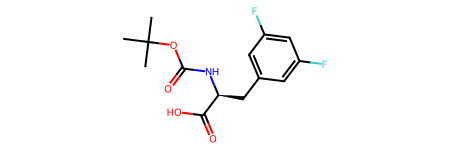

In [10]:
Chem.MolFromSmiles(sel_vir_comb_df_sorted.iloc[5]['Ligand'])